In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib.colors as mcolors
import seaborn as sns
import os

densely_dashdotted = (0, (3, 1, 1, 1))
long_dash_with_offset = (5, (10, 3))
line_styles = ['solid', 'dashed', 'dashdot', densely_dashdotted, long_dash_with_offset, 'dotted']

orig_colors = ['red', 'gray', 'green', 'blue']
orig_colors1 = sns.color_palette("colorblind")

colorsets = [
    orig_colors[0],
    orig_colors[1],
    orig_colors[2],
    orig_colors[3],
    'black',
    orig_colors1[3],
    orig_colors1[4],
    mcolors.TABLEAU_COLORS['tab:olive'],
]

base_plots_path = 'plots/kv_pattern_plots/'
os.makedirs(base_plots_path, exist_ok=True)

kv_pattern_data_path = 'kv_pattern_data/'

In [4]:
TOKENS_PER_BLOCK = 16
# 4096 is the dimension of Yarn-Llama model
SIZE_PER_BLOCK = (TOKENS_PER_BLOCK * 4096 * 2)

In [5]:
def read_data(file):
    data = []
    with open(file, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def read_layer_step_keys(dt, layer_id, step):
    # read the key_start, key_end position data
    key_start, key_end = None, None
    seqs = None
    start_time, end_times = 0, None 
    for item in dt:
        if item['layer_id'] == layer_id and item['step'] == step:
            start_time = item['start_time']
            seqs = item['seq_lens']
            key_start = [x[0] for x in item['kv_write_pattern_record']]
            key_end = [x[1] for x in item['kv_write_pattern_record']]
            end_times = [x[4] for x in item['kv_write_pattern_record']]

    results = {}
    r_s, r_e = 0, 0
    for i in range(len(seqs)):
        r_e = r_s + seqs[i]
        key_start_pos = key_start[r_s:r_e]
        key_end_pos = key_end[r_s:r_e]
        end_time_pos = end_times[r_s:r_e]
        results[i] = {'key_start': key_start_pos, 'key_end': key_end_pos, 'end_time': end_time_pos}
        r_s = r_e

    return start_time, results

def read_layer_step_values(dt, layer_id, step):
    # read the key_start, key_end position data
    key_start, key_end = None, None
    seqs = None
    start_time, end_times = 0, None 
    for item in dt:
        if item['layer_id'] == layer_id and item['step'] == step:
            start_time = item['start_time']
            seqs = item['seq_lens']
            value_start = [x[2] for x in item['kv_write_pattern_record']]
            value_end = [x[3] for x in item['kv_write_pattern_record']]
            end_times = [x[4] for x in item['kv_write_pattern_record']]

    results = {}
    r_s, r_e = 0, 0
    for i in range(len(seqs)):
        r_e = r_s + seqs[i]
        value_start_pos = value_start[r_s:r_e]
        value_end_pos = value_end[r_s:r_e]
        end_time_pos = end_times[r_s:r_e]
        results[i] = {'value_start': value_start_pos, 'value_end': value_end_pos, 'end_time': end_time_pos}
        r_s = r_e

    return start_time, results


def get_start_time(dt, layer_id, step):
    for item in dt:
        if item['layer_id'] == layer_id and item['step'] == step:
            return item['start_time']

    return None

def get_kv_range(dt, layer_id, step):
    for item in dt:
        if item['layer_id'] == layer_id and item['step'] == step:
            return item['kv_cache_range']

    return None

def xaxis_formatter(x, pos):
    return '%.1f' % x


In [6]:
def plot_key_wr_pattern(dt, reqs_lens, layer_id, is_nameY_block=True):
    req_nums = len(reqs_lens)
    flags =[0] * req_nums # 0: incomplete, 1: complete
    # only plot the first 5 steps
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(8, 3), width_ratios=[1, 1, 1, 1, 1], constrained_layout=True)

    steps = 5
    # get start time for layer 0 step 1
    start = get_start_time(dt, 0, 1)

    cur_r_lens = [0] * req_nums
    for i in range(steps):
        # get data for each step
        start_time, results = read_layer_step_keys(dt, layer_id, i+1)
        start_pos = (start_time - start) * 1e3 # convert to us
        for idx, r in enumerate(results.keys()):
            idx_1 = idx
            while True:
                if flags[idx_1] == 1:
                    idx_1 += 1
                else:
                    break
            if idx_1 >= req_nums:
                break
            cur_r_lens[idx_1] += len(results[r]['key_start'])
            if cur_r_lens[idx_1] >= reqs_lens[idx_1] - 1:
                flags[idx_1] = 1
            token_block_id = [ x // SIZE_PER_BLOCK for x in results[r]['key_start']]
            if i == 0:
                print(f"R{idx_1}, idx_1: {idx_1}, Token block id: {token_block_id}")
            token_offset = [(x % SIZE_PER_BLOCK) // TOKENS_PER_BLOCK for x in results[r]['key_start']]
            end_time_pos = [x/1e3 + start_pos for x in results[r]['end_time']]
            if i == 1:
                print(f"R{idx_1}, idx_1: {idx_1}, start_pos: {start_pos}, end_time_pos {end_time_pos}")
            # axs[i].barh(token_block_id, end_time_pos, left=start_pos, color=colorsets[idx_1], label=f'Req{idx_1}')
            axs[i].hlines(token_block_id, start_pos, end_time_pos, color=colorsets[idx_1], label=f'R{idx_1}', linestyle=line_styles[idx_1], linewidth=1)

            axs[i].set_xlim(start_pos, np.max(end_time_pos) + 0.1)
            axs[i].set_xticks(np.arange(start_pos, np.max(end_time_pos) + 0.1, 0.1))
            axs[i].xaxis.set_major_formatter(plt.FuncFormatter(xaxis_formatter))
            # print(f"Start pos: {start_pos} End pos: {start_pos + np.max(end_time_pos) + 0.1}")

        for label in axs[i].get_xticklabels():
            label.set_rotation(270)


    axs[0].text(np.mean([-0.1, 0.2]), 310, 'F1(prefill)', fontsize=10, color='r', fontweight='bold')
    axs[1].text(np.mean([129.18, 129.32]), 310, 'F2(decode)', fontsize=10, color='b', fontweight='bold')
    axs[2].text(np.mean([155.75, 156.0]), 310, 'F3(decode)', fontsize=10, color='b', fontweight='bold')
    axs[3].text(np.mean([181.91, 182.1]), 310, 'F4(decode)', fontsize=10, color='b', fontweight='bold')
    axs[4].text(np.mean([208.1, 208.31]), 310, 'F5(decode)', fontsize=10, color='b', fontweight='bold')

    # hide the spines between ax and ax2
    for i in range(steps):
        if i == 0:
            axs[i].spines['right'].set_visible(False)
            axs[i].yaxis.tick_left()
        elif i == steps - 1:
            axs[i].spines['left'].set_visible(False)
            axs[i].yaxis.tick_right()
        else:
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['left'].set_visible(False) 
            axs[i].tick_params(axis='y', which='both', length=0)

    d = .008  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    for i in range(steps):
        kwargs = dict(transform=axs[i].transAxes, color='k', clip_on=False)
        if i == 0:
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
        elif i == steps - 1:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)
        else:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[0].set_yticks(np.arange(215, 315, 5))
    axs[0].set_ylim(215, 305)
    if is_nameY_block:
        axs[0].set_ylabel('Key/Value Cache Block ID')
    else:
        axs[0].set_ylabel('Key/Value Cache Chunk ID')
    fig.text(0.5, -0.03, 'Time (ms)', ha='center', va='center', fontsize=10)
    
    handles, labels = axs.flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.88), ncol=4, borderpad=0.1, 
           labelspacing=0.2, columnspacing=0.5, frameon=True, fontsize=10)

    plt.savefig(f"{base_plots_path}/KV_write_pattern_over_time(layer_0)_chunk.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{base_plots_path}/KV_write_pattern_over_time(layer_0)_chunk.png", format='png', bbox_inches='tight')
    plt.show()

In [7]:
def plot_value_wr_pattern(dt, reqs_lens, layer_id):
    req_nums = len(reqs_lens)
    flags =[0] * req_nums # 0: incomplete, 1: complete
    # only plot the first 5 steps
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(8, 3), width_ratios=[2, 1, 1, 1, 1], constrained_layout=True)

    steps = 5
    # get start time for layer 0 step 1
    start = get_start_time(dt, 0, 1)

    cur_r_lens = [0] * req_nums
    for i in range(steps):
        # get data for each step
        start_time, results = read_layer_step_values(dt, layer_id, i+1)
        start_pos = (start_time - start) * 1e3 # convert to us
        for idx, r in enumerate(results.keys()):
            idx_1 = idx
            while True:
                if flags[idx_1] == 1:
                    idx_1 += 1
                else:
                    break
            if idx_1 >= req_nums:
                break
            cur_r_lens[idx_1] += len(results[r]['value_start'])
            if cur_r_lens[idx_1] >= reqs_lens[idx_1] - 1:
                flags[idx_1] = 1
            token_block_id = [ x // SIZE_PER_BLOCK for x in results[r]['value_start']]
            if i == 0:
                print(f"R{idx_1}, idx_1: {idx_1}, Token block id: {token_block_id}")
            token_offset = [(x % SIZE_PER_BLOCK) // TOKENS_PER_BLOCK for x in results[r]['value_start']]
            end_time_pos = [x/1e3 + start_pos for x in results[r]['end_time']]
            if i == 1:
                print(f"R{idx_1}, idx_1: {idx_1}, start_pos: {start_pos}, end_time_pos {end_time_pos}")
            # axs[i].barh(token_block_id, end_time_pos, left=start_pos, color=colorsets[idx_1], label=f'Req{idx_1}')
            axs[i].hlines(token_block_id, start_pos, end_time_pos, color=colorsets[idx_1], label=f'R{idx_1}', linestyle=line_styles[idx_1], linewidth=1)

            axs[i].set_xlim(start_pos, np.max(end_time_pos) + 0.1)
            axs[i].set_xticks(np.arange(start_pos, np.max(end_time_pos) + 0.1, 0.1))
            axs[i].xaxis.set_major_formatter(plt.FuncFormatter(xaxis_formatter))
            # print(f"Start pos: {start_pos} End pos: {start_pos + np.max(end_time_pos) + 0.1}")
        
        for label in axs[i].get_xticklabels():
            label.set_rotation(45)

    # hide the spines between ax and ax2
    for i in range(steps):
        if i == 0:
            axs[i].spines['right'].set_visible(False)
            axs[i].yaxis.tick_left()
        elif i == steps - 1:
            axs[i].spines['left'].set_visible(False)
            axs[i].yaxis.tick_right()
        else:
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['left'].set_visible(False) 
            axs[i].tick_params(axis='y', which='both', length=0)

    d = .008  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    for i in range(steps):
        kwargs = dict(transform=axs[i].transAxes, color='k', clip_on=False)
        if i == 0:
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
        elif i == steps - 1:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)
        else:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[0].set_yticks(np.arange(215, 310, 5))
    axs[0].set_ylim(215, 305)
    axs[0].set_ylabel('Key/Value Cache Block ID')
    axs[2].set_xlabel('Time (ms)')

    handles, labels = axs.flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98), ncol=3, borderpad=0.1, 
           labelspacing=0.2, columnspacing=0.5, frameon=True, fontsize=10)

    # ax.set_xticks(np.arange(0, 100, 20))
    # ax.legend()
    plt.savefig(f"{base_plots_path}/KV_write_pattern_over_time(layer_0)_value.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{base_plots_path}/KV_write_pattern_over_time(layer_0)_value.png", format='png', bbox_inches='tight')
    plt.show()

kv_range address range of a transformer block =  39714816
R0, idx_1: 0, Token block id: [302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302]
R1, idx_1: 1, Token block id: [301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 292, 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


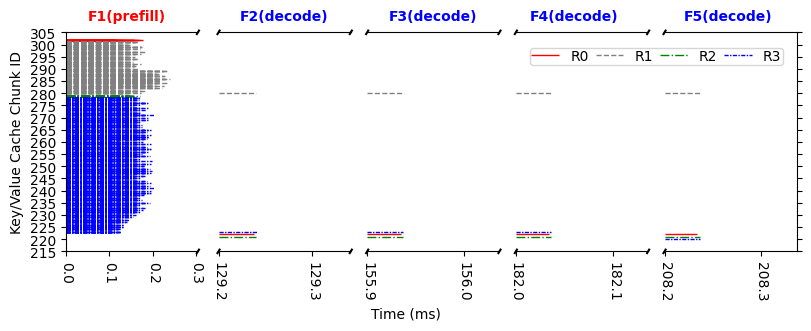

In [8]:
data = read_data(f'{kv_pattern_data_path}/kv_write_pattern.json')
kv_range = get_kv_range(data, 0, 1)
print("kv_range address range of a transformer block = ", kv_range)
blocks = kv_range // SIZE_PER_BLOCK

# plot key write pattern
reqs_lens = [21, 348, 21, 898, 12]
layer_id = 0
plot_key_wr_pattern(data, reqs_lens, layer_id, False)

In [9]:
def read_layer_step_key_access_pattern(dt, layer_id, step_id, s_time, read_type='k_read_pattern_record'):
    info = None
    for item in dt:
        if item['layer_id'] == layer_id and item['step'] == step_id:
            info = item
            break
    # get the req_stride, and inner stride
    req_stride = info['req_stride']
    inner_stride = info['block_acc_stride']
    seqs = info['seq_lens']
    start_time = info['start_time']
    # print(f"Start time: {start_time}, s_time: {s_time}")
    abs_start_time = (start_time - s_time) * 1e3
    reqs_keys_start_time = {}
    reqs_keys_end_time = {}
    reqs_keys_blockIds = {}

    for i in range(len(seqs)):
        if read_type == 'k_read_pattern_record': 
            req_i = info['k_read_pattern_record'][i]
        else:
            req_i = info['v_read_pattern_record'][i]
        # print(f"Req_{i} = {req_i}")
        for j in range(0, req_stride, 3):
            if req_i[j] == -1:
                continue
            if i not in reqs_keys_start_time:
                reqs_keys_start_time[i] = [req_i[j + 0]/1e3 + abs_start_time]
                reqs_keys_end_time[i] = [req_i[j + 0]/1e3 + req_i[j + 1]/1e3 + abs_start_time]
                reqs_keys_blockIds[i] = [req_i[j + 2]]
            else:
                reqs_keys_start_time[i].append(req_i[j + 0]/1e3 + abs_start_time)
                reqs_keys_end_time[i].append(req_i[j + 0]/1e3 + req_i[j + 1]/1e3 + abs_start_time)
                reqs_keys_blockIds[i].append(req_i[j + 2])

    return reqs_keys_start_time, reqs_keys_end_time, reqs_keys_blockIds 

# Plot Key/Value read pattern over time
def plot_key_read_pattern(dt, layer_id, s_time, step1_dur): 
    # only plot the first 5 steps
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(8, 3), width_ratios=[1, 1, 1, 1, 1], constrained_layout=True)

    steps = 5
    
    for i in range(steps):
        if i == 0:
            # skip step 1 since step 1 has no key value read
            axs[i].set_xlim(0, step1_dur) 
            continue
        # get data for each step
        reqs_keys_start_time, reqs_keys_end_time, reqs_keys_blockIds =  read_layer_step_key_access_pattern(dt, layer_id, i+1, s_time, 'k_read_pattern_record')
        for req_idx in reqs_keys_start_time.keys():
            # each key refers a request
            # axs[i].barh(token_block_id, end_time_pos, left=start_pos, color=colorsets[idx_1], label=f'Req{idx_1}')
            axs[i].hlines(reqs_keys_blockIds[req_idx], reqs_keys_start_time[req_idx], reqs_keys_end_time[req_idx], color=colorsets[req_idx], label=f'R{req_idx}', linestyle=line_styles[req_idx], linewidth=1)
            min_start, max_start = np.min(reqs_keys_start_time[req_idx]), np.max(reqs_keys_start_time[req_idx])
            axs[i].set_xlim(min_start, max_start + 0.21)
            axs[i].set_xticks(np.arange(min_start, max_start + 0.21, 0.2))
            axs[i].xaxis.set_major_formatter(plt.FuncFormatter(xaxis_formatter))
            # print(f"Start pos: {start_pos} End pos: {start_pos + np.max(end_time_pos) + 0.1}")

    # hide the spines between ax and ax2
    for i in range(steps):
        if i == 0:
            axs[i].spines['right'].set_visible(False)
            axs[i].yaxis.tick_left()
        elif i == steps - 1:
            axs[i].spines['left'].set_visible(False)
            axs[i].yaxis.tick_right()
        else:
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['left'].set_visible(False) 
            axs[i].tick_params(axis='y', which='both', length=0)

    d = .008  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    for i in range(steps):
        kwargs = dict(transform=axs[i].transAxes, color='k', clip_on=False)
        if i == 0:
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
        elif i == steps - 1:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)
        else:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[0].set_yticks(np.arange(210, 305, 5))
    axs[0].set_ylim(210, 305)
    axs[0].set_ylabel('Key Cache Block ID')
    axs[2].set_xlabel('Time (ms)')
    handles, labels = axs.flat[1].get_legend_handles_labels()
    print(labels)
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.25, 0.98), ncol=1, borderpad=0.1, 
           labelspacing=0.2, columnspacing=0.5, frameon=True, fontsize=10)

    plt.savefig(f"{base_plots_path}/Key_read_pattern_over_time(layer_0).eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{base_plots_path}/Key_read_pattern_over_time(layer_0).png", format='png', bbox_inches='tight')
    plt.show()

def plot_value_read_pattern(dt, layer_id, s_time, step1_dur): 
    # only plot the first 5 steps
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(8, 3), width_ratios=[1, 1, 1, 1, 1], constrained_layout=True)

    steps = 5
    
    for i in range(steps):
        if i == 0:
            # skip step 1 since step 1 has no key value read
            axs[i].set_xlim(0, step1_dur) 
            continue
        # get data for each step
        reqs_values_start_time, reqs_values_end_time, reqs_values_blockIds =  read_layer_step_key_access_pattern(dt, layer_id, i+1, s_time, 'v_read_pattern_record')
        min_start, max_start = None, None
        for req_idx in reqs_values_start_time.keys():
            # each key refers a request
            # print(f"Req_{req_idx} = {reqs_values_start_time[req_idx]}") 
            # print(f"Req_{req_idx} = {reqs_values_blockIds[req_idx]}")
            # axs[i].barh(token_block_id, end_time_pos, left=start_pos, color=colorsets[idx_1], label=f'Req{idx_1}')
            axs[i].hlines(reqs_values_blockIds[req_idx], reqs_values_start_time[req_idx], reqs_values_end_time[req_idx], color=colorsets[req_idx], label=f'R{req_idx}', linestyle=line_styles[req_idx], linewidth=1)
            if min_start is None:
                min_start, max_start = np.min(reqs_values_start_time[req_idx]), np.max(reqs_values_end_time[req_idx])
            else:
                if min_start > np.min(reqs_values_start_time[req_idx]):
                    min_start = np.min(reqs_values_start_time[req_idx])
                if max_start < np.max(reqs_values_end_time[req_idx]):
                    max_start = np.max(reqs_values_end_time[req_idx])
            axs[i].set_xlim(min_start, max_start + 0.21)
            axs[i].set_xticks(np.arange(min_start, max_start + 0.21, 0.2))
            axs[i].xaxis.set_major_formatter(plt.FuncFormatter(xaxis_formatter))
            # print(f"Start pos: {start_pos} End pos: {start_pos + np.max(end_time_pos) + 0.1}")

    # hide the spines between ax and ax2
    for i in range(steps):
        if i == 0:
            axs[i].spines['right'].set_visible(False)
            axs[i].yaxis.tick_left()
        elif i == steps - 1:
            axs[i].spines['left'].set_visible(False)
            axs[i].yaxis.tick_right()
        else:
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['left'].set_visible(False) 
            axs[i].tick_params(axis='y', which='both', length=0)

    d = .008  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    for i in range(steps):
        kwargs = dict(transform=axs[i].transAxes, color='k', clip_on=False)
        if i == 0:
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
        elif i == steps - 1:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)
        else:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[0].set_yticks(np.arange(210, 305, 5))
    axs[0].set_ylim(210, 305)
    axs[0].set_ylabel('Value Cache Block ID')
    axs[2].set_xlabel('Time (ms)')
    handles, labels = axs.flat[1].get_legend_handles_labels()
    print(labels)
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.25, 0.98), ncol=1, borderpad=0.1, 
           labelspacing=0.2, columnspacing=0.5, frameon=True, fontsize=10)

    plt.savefig(f"{base_plots_path}/Value_read_pattern_over_time(layer_0).eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{base_plots_path}/Value_read_pattern_over_time(layer_0).png", format='png', bbox_inches='tight')
    plt.show()


# plot key-value read pattern together
def plot_key_value_read_pattern(dt, layer_id, s_time, step1_dur): 
    # only plot the first 5 steps
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(8, 3), width_ratios=[1, 1, 1, 1, 1], constrained_layout=True)

    steps = 5

    for i in range(steps):
        if i == 0:
            # skip step 1 since step 1 has no key value read
            axs[i].set_xlim(0, step1_dur)
            for label in axs[i].get_xticklabels():
                label.set_rotation(270)
            continue
        # get key read data for each step
        reqs_keys_start_time, reqs_keys_end_time, reqs_keys_blockIds =  read_layer_step_key_access_pattern(dt, layer_id, i+1, s_time, 'k_read_pattern_record')
        reqs_values_start_time, reqs_values_end_time, reqs_values_blockIds =  read_layer_step_key_access_pattern(dt, layer_id, i+1, s_time, 'v_read_pattern_record') 
        min_start, max_end = None, None 
        for req_idx in reqs_keys_start_time.keys():
            # each key refers a request
            # axs[i].barh(token_block_id, end_time_pos, left=start_pos, color=colorsets[idx_1], label=f'Req{idx_1}')
            axs[i].hlines(reqs_keys_blockIds[req_idx], reqs_keys_start_time[req_idx], reqs_keys_end_time[req_idx], color=colorsets[req_idx], label=f'R{req_idx}-Key', linestyle=line_styles[req_idx], linewidth=1)
            axs[i].hlines(reqs_values_blockIds[req_idx], reqs_values_start_time[req_idx], reqs_values_end_time[req_idx], color=colorsets[req_idx+4], label=f'R{req_idx}-Value', linestyle=line_styles[req_idx], linewidth=1) 
            # min_start, max_end = np.min(reqs_keys_start_time[req_idx]), np.max(reqs_values_end_time[req_idx])
            if min_start is None:
                min_start, max_end = np.min(reqs_keys_start_time[req_idx]), np.max(reqs_values_end_time[req_idx])
            else:
                if min_start > np.min(reqs_keys_start_time[req_idx]):
                    min_start = np.min(reqs_keys_start_time[req_idx])
                if max_end < np.max(reqs_values_end_time[req_idx]):
                    max_end = np.max(reqs_values_end_time[req_idx])
            axs[i].set_xlim(min_start, max_end + 0.1)
            axs[i].set_xticks(np.arange(min_start, max_end + 0.1, 0.1))
            axs[i].xaxis.set_major_formatter(plt.FuncFormatter(xaxis_formatter))
            
        # Add rotation for x-axis labels
        for label in axs[i].get_xticklabels():
            label.set_rotation(270)  # You can adjust this angle to your preference

    axs[0].text(np.mean([-50, 100]), 310, 'F1(prefill)', fontsize=10, color='r', fontweight='bold')
    axs[1].text(np.mean([129.0, 129.6]), 310, 'F2(decode)', fontsize=10, color='b', fontweight='bold')
    axs[2].text(np.mean([155.6, 156.2]), 310, 'F3(decode)', fontsize=10, color='b', fontweight='bold')
    axs[3].text(np.mean([181.7, 182.4]), 310, 'F4(decode)', fontsize=10, color='b', fontweight='bold')
    axs[4].text(np.mean([207.9, 208.6]), 310, 'F5(decode)', fontsize=10, color='b', fontweight='bold')

    # hide the spines between ax and ax2
    for i in range(steps):
        if i == 0:
            axs[i].spines['right'].set_visible(False)
            axs[i].yaxis.tick_left()
        elif i == steps - 1:
            axs[i].spines['left'].set_visible(False)
            axs[i].yaxis.tick_right()
        else:
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['left'].set_visible(False) 
            axs[i].tick_params(axis='y', which='both', length=0)

    d = .008  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    for i in range(steps):
        kwargs = dict(transform=axs[i].transAxes, color='k', clip_on=False)
        if i == 0:
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
        elif i == steps - 1:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)
        else:
            axs[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            axs[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)
            axs[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
            axs[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    
    
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[0].set_yticks(np.arange(215, 305, 5))
    axs[0].set_ylim(215, 305)
    # axs[0].set_ylabel('Key/Value Cache Block ID')
    axs[0].set_ylabel('Key/Value Cache Chunk ID')
    axs[2].set_xlabel('Time (ms)')
    handles, labels = axs.flat[1].get_legend_handles_labels()
    print(labels)
    fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.22, 0.25), ncol=1, borderpad=0.1, 
           labelspacing=0.2, columnspacing=0.5, frameon=True, fontsize=10)

    plt.savefig(f"{base_plots_path}/KV_read_pattern_over_time(layer_0)_chunk.eps", format='eps', bbox_inches='tight')
    plt.savefig(f"{base_plots_path}/KV_read_pattern_over_time(layer_0)_chunk.png", format='png', bbox_inches='tight')
    plt.show()

step1_dur:  0.12156176567077637
['R0-Key', 'R0-Value', 'R1-Key', 'R1-Value', 'R2-Key', 'R2-Value', 'R3-Key', 'R3-Value']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


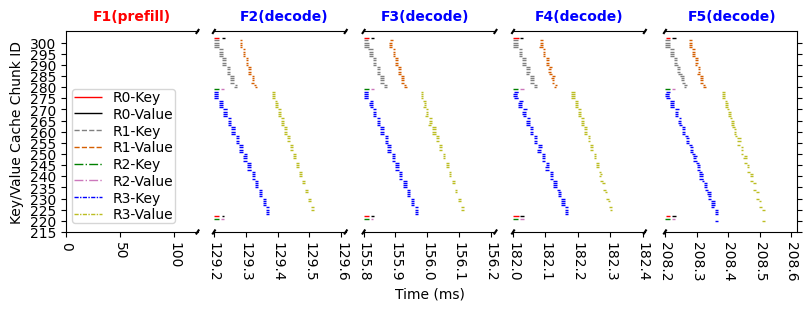

In [10]:
wt_data = read_data(f'{kv_pattern_data_path}/kv_write_pattern.json')
rd_data = read_data(f'{kv_pattern_data_path}/kv_read_pattern.json')
s_time = get_start_time(wt_data, 0, 1)
s2_time = get_start_time(wt_data, 31, 1)
step1_dur = (s2_time - s_time) * 1e3
print(f"step1_dur: ", s2_time - s_time)

plot_key_value_read_pattern(rd_data, 0, s_time, step1_dur)
